# Задание 3. 6 баллов

Реализуйте следующие классы (указана сигнатура __init__):
- BaseTransform(p: float) [*базовый класс для всех трансформаций*]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor() 
- Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других.
При вызове метода __call__ он должен последовательно вызывать трансформации из списка.
При вызове каждого из них с вероятностью p должно 
применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное 
изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже.
Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

**torch.nn использовать нельзя!**

Вспомогательное

In [12]:
import random
import unittest
from typing import List, Tuple, Union, Any
import numpy as np
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


def create_complex_image(width=200, height=200):
    """Creates a more complex image with shapes and colors."""
    img = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(img)

    # Draw some rectangles
    draw.rectangle([20, 20, 80, 80], fill='red', outline='black')
    draw.rectangle([120, 120, 180, 180], fill='blue', outline='black')

    # Draw some circles
    draw.ellipse([100, 20, 180, 100], fill='green', outline='black')
    draw.ellipse([20, 120, 100, 180], fill='yellow', outline='black')

    # Draw a line
    draw.line([0, 0, width, height], fill='black', width=3)
    draw.line([0, height, width, 0], fill='black', width=3)

    return img


Трансформации

In [13]:
class BaseTransform:
    def __init__(self, p: float):
        self.p = p

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError


class RandomCrop(BaseTransform):
    def __init__(self, p: float, **kwargs):
        super().__init__(p)
        self.size = kwargs.get('size')
        if isinstance(self.size, int):
            self.size = (self.size, self.size)
        if self.size is None:
            raise ValueError("RandomCrop requires 'size' in kwargs")

    def apply(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        th, tw = self.size

        # If image is smaller than crop size, resize it
        if w < tw or h < th:
            scale = max(tw / w, th / h)
            new_w = int(w * scale) + 1
            new_h = int(h * scale) + 1
            img = img.resize((new_w, new_h), Image.BILINEAR)
            w, h = img.size

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return img.crop((j, i, j + tw, i + th))


class RandomRotate(BaseTransform):
    def __init__(self, p: float, **kwargs):
        super().__init__(p)
        self.degrees = kwargs.get('degrees')
        if isinstance(self.degrees, (int, float)):
            self.degrees = (-abs(self.degrees), abs(self.degrees))
        if self.degrees is None:
            raise ValueError("RandomRotate requires 'degrees' in kwargs")

    def apply(self, img: Image.Image) -> Image.Image:
        angle = random.uniform(self.degrees[0], self.degrees[1])
        return img.rotate(angle)


class RandomZoom(BaseTransform):
    def __init__(self, p: float, **kwargs):
        super().__init__(p)
        self.scale = kwargs.get('scale', (0.8, 1.2))
        if 'min_scale' in kwargs and 'max_scale' in kwargs:
            self.scale = (kwargs['min_scale'], kwargs['max_scale'])

    def apply(self, img: Image.Image) -> Image.Image:
        s = random.uniform(self.scale[0], self.scale[1])
        w, h = img.size

        # Resize the image
        new_w = int(w * s)
        new_h = int(h * s)
        img_resized = img.resize((new_w, new_h), Image.BILINEAR)

        # If zoomed in (s > 1), crop the center
        if s > 1.0:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            right = left + w
            bottom = top + h
            return img_resized.crop((left, top, right, bottom))

        # If zoomed out (s < 1), pad with black borders
        else:
            new_img = Image.new(img.mode, (w, h), (0, 0, 0))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            new_img.paste(img_resized, (left, top))
            return new_img


class ToTensor:
    def __call__(self, img: Image.Image) -> torch.Tensor:
        arr = np.array(img)

        # Handle grayscale (H, W) -> (H, W, 1)
        if arr.ndim == 2:
            arr = arr[:, :, None]

        # (H, W, C) -> (C, H, W)
        arr = arr.transpose((2, 0, 1))

        tensor = torch.from_numpy(arr)

        # Normalize if uint8
        if tensor.dtype == torch.uint8:
            tensor = tensor.float() / 255.0
        else:
            tensor = tensor.float()

        return tensor


class Compose:
    def __init__(self, transforms: List[Any]):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img


Запуск

Generating demonstration image...
Demonstration saved to homeworks/hw2/transform_demo.png


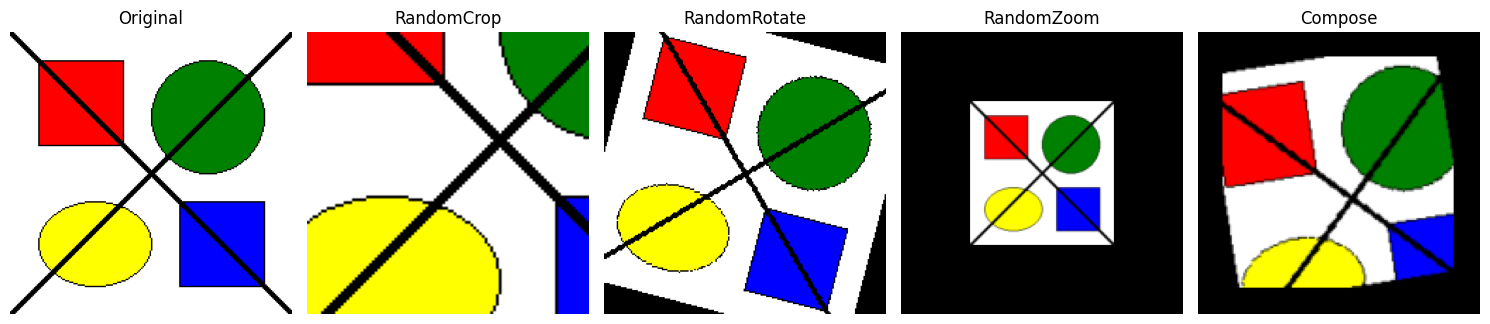

In [ ]:
print("Generating demonstration image...")
original = create_complex_image()
random.seed(45) # наиболее наглядное

transforms_list = [
	("Original", None),
	("RandomCrop", RandomCrop(p=1.0, size=100)),
	("RandomRotate", RandomRotate(p=1.0, degrees=45)),
	("RandomZoom", RandomZoom(p=1.0, scale=(0.5, 1.5))),
	("Compose", Compose([
		RandomCrop(p=1.0, size=150),
		RandomRotate(p=1.0, degrees=30),
		RandomZoom(p=1.0, scale=(0.8, 1.2))
	]))
]

fig, axes = plt.subplots(1, len(transforms_list), figsize=(15, 4))

for idx, (name, transform) in enumerate(transforms_list):
	if transform:
		res = transform(original)
	else:
		res = original

	axes[idx].imshow(res)
	axes[idx].set_title(name)
	axes[idx].axis('off')

plt.tight_layout()
plt.savefig("transform_demo.png")
print("Demonstration saved to homeworks/hw2/transform_demo.png")
plt.show()


{*} (1 балл) Протестируйте ваши классы на воспроизводимость, результат, граничные случаи.

In [ ]:
class TestTransforms(unittest.TestCase):
    def setUp(self):
        self.img = create_complex_image(100, 100)

    def test_random_crop_size(self):
        crop = RandomCrop(p=1.0, size=50)
        out = crop(self.img)
        self.assertEqual(out.size, (50, 50))

    def test_random_crop_resize(self):
        # Test when crop size is larger than image
        crop = RandomCrop(p=1.0, size=150)
        out = crop(self.img)
        self.assertEqual(out.size, (150, 150))

    def test_random_rotate(self):
        rot = RandomRotate(p=1.0, degrees=90)
        out = rot(self.img)
        # Rotate keeps original size by default in PIL unless expand=True (which is not used here)
        self.assertEqual(out.size, (100, 100))

    def test_random_zoom(self):
        # Test zoom out (should pad)
        zoom = RandomZoom(p=1.0, scale=(0.5, 0.5))
        out = zoom(self.img)
        self.assertEqual(out.size, (100, 100))  # Size should be preserved

        # Test zoom in (should crop)
        zoom_up = RandomZoom(p=1.0, scale=(2.0, 2.0))
        out_up = zoom_up(self.img)
        self.assertEqual(out_up.size, (100, 100))  # Size should be preserved

    def test_to_tensor(self):
        to_tensor = ToTensor()
        out = to_tensor(self.img)
        self.assertIsInstance(out, torch.Tensor)
        self.assertEqual(out.shape, (3, 100, 100))
        self.assertTrue(out.max() <= 1.0)
        self.assertTrue(out.min() >= 0.0)

    def test_compose(self):
        pipeline = Compose([
            RandomCrop(p=1.0, size=50),
            RandomRotate(p=1.0, degrees=45),
            ToTensor()
        ])
        out = pipeline(self.img)
        self.assertIsInstance(out, torch.Tensor)
        self.assertEqual(out.shape, (3, 50, 50))

    def test_reproducibility(self):
        random.seed(42)
        pipeline = Compose([RandomCrop(p=1.0, size=50)])
        out1 = pipeline(self.img)

        random.seed(42)
        pipeline = Compose([RandomCrop(p=1.0, size=50)])
        out2 = pipeline(self.img)

        self.assertEqual(out1.tobytes(), out2.tobytes())

    def test_probability_zero(self):
        # With p=0, image should not change
        crop = RandomCrop(p=0.0, size=50)
        out = crop(self.img)
        self.assertEqual(out.size, (100, 100))
        self.assertEqual(out.tobytes(), self.img.tobytes())


unittest.main(argv=['first-arg-is-ignored'], exit=False)


........
----------------------------------------------------------------------
Ran 8 tests in 0.007s

OK
